<a href="https://colab.research.google.com/github/eliot28/desafioLatam/blob/main/tutoria_6_series_tiempo_g80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

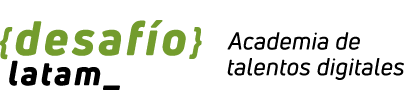
#<center><font color ='green'>Ejercicio Guiado</font></center>

In [ ]:
!pip install pmdarima #importante
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.6 MB/s eta 0:00:00


In [ ]:
# Cargamod el conjunto de datos "Air Passengers" desde seaborn
df = sns.load_dataset("flights")
df.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [ ]:

# Convertir la columna 'year' y 'month' a formato de fecha
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str), errors='coerce')
df = df.drop(['year', 'month'], axis=1)

# utilizando la columna “year” y la columna “month” se construye la columna “date.

time_series = df.set_index('date')
df.head()

<ipython-input-3-0c54c9aea0f4>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str), errors='coerce')


,passengers,date
0,112,1949-01-01
1,118,1949-02-01
2,132,1949-03-01
3,129,1949-04-01
4,121,1949-05-01


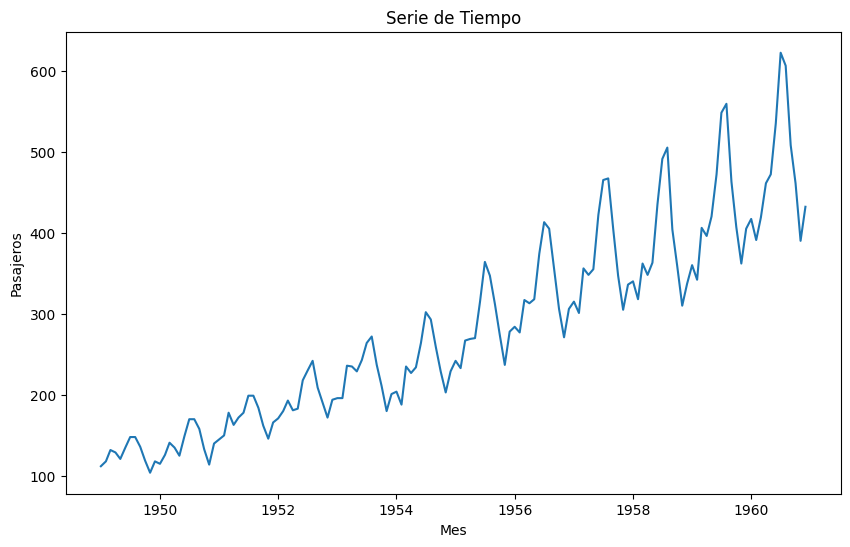

In [ ]:
# Mostrar el gráfico de la serie de tiempo
plt.figure(figsize=(10, 6))
plt.plot(time_series)
plt.title("Serie de Tiempo")
plt.xlabel("Mes")
plt.ylabel("Pasajeros")
plt.show()

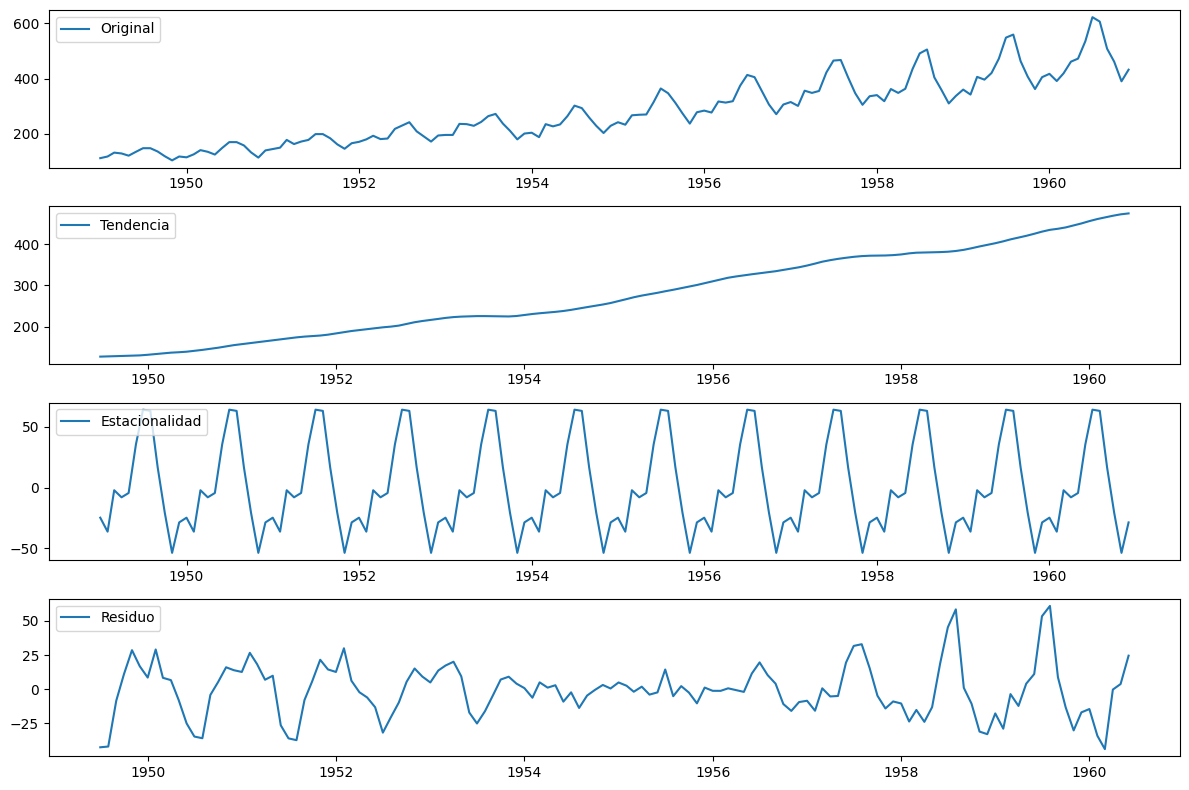

In [ ]:
# Descomposición de la serie de tiempo en componentes
result = seasonal_decompose(time_series, model='additive')
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Mostrar los componentes descompuestos
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(time_series, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuo')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Se observa claramente una tendencia creciente en el tiempo y una estacionalidad clara.

Ahora procedemos a Dickey-Fuller, para ver el valor de “d”. Vamos a restar la serie de tiempo hasta volverla estacionaria y poder escoger los parámetros.


In [ ]:
d = 0
p_value = adfuller(df['passengers'])[1]
diff_data = df['passengers']

while p_value > 0.05:
    diff_data = diff_data.diff()
    p_value = adfuller(diff_data.dropna())[1]
    d += 1


print(f'P Value: {p_value}\t Number of differencing needed: {d}')

P Value: 2.7328918500142026e-29	 Number of differencing needed: 2


Se observa claramente una tendencia creciente en el tiempo y una estacionalidad clara.

Ahora procedemos a Dickey-Fuller, para ver el valor de “d”. Vamos a restar la serie de tiempo hasta volverla estacionaria y poder escoger los parámetros.


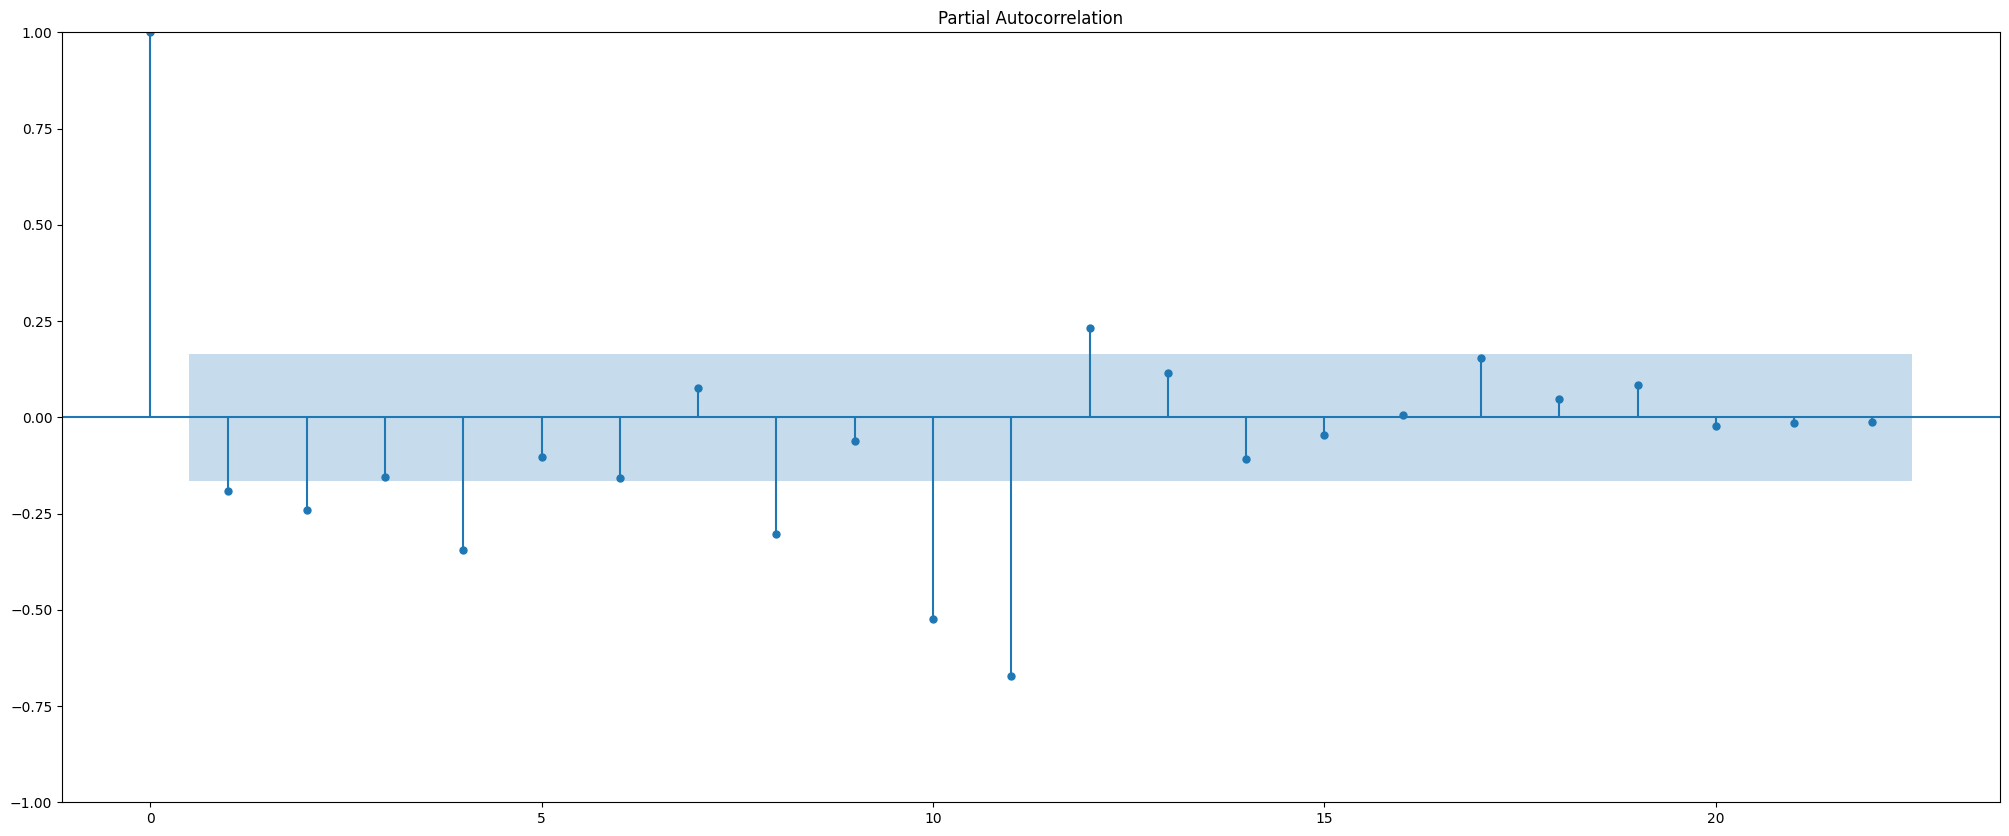

In [ ]:
fig, ax = plt.subplots(figsize=(25, 10))
plot_pacf(diff_data.dropna(), ax=ax)
plt.show()

El último valor significativo es 11.

Ahora utilizamos la función de correlación para obtener el último valor.


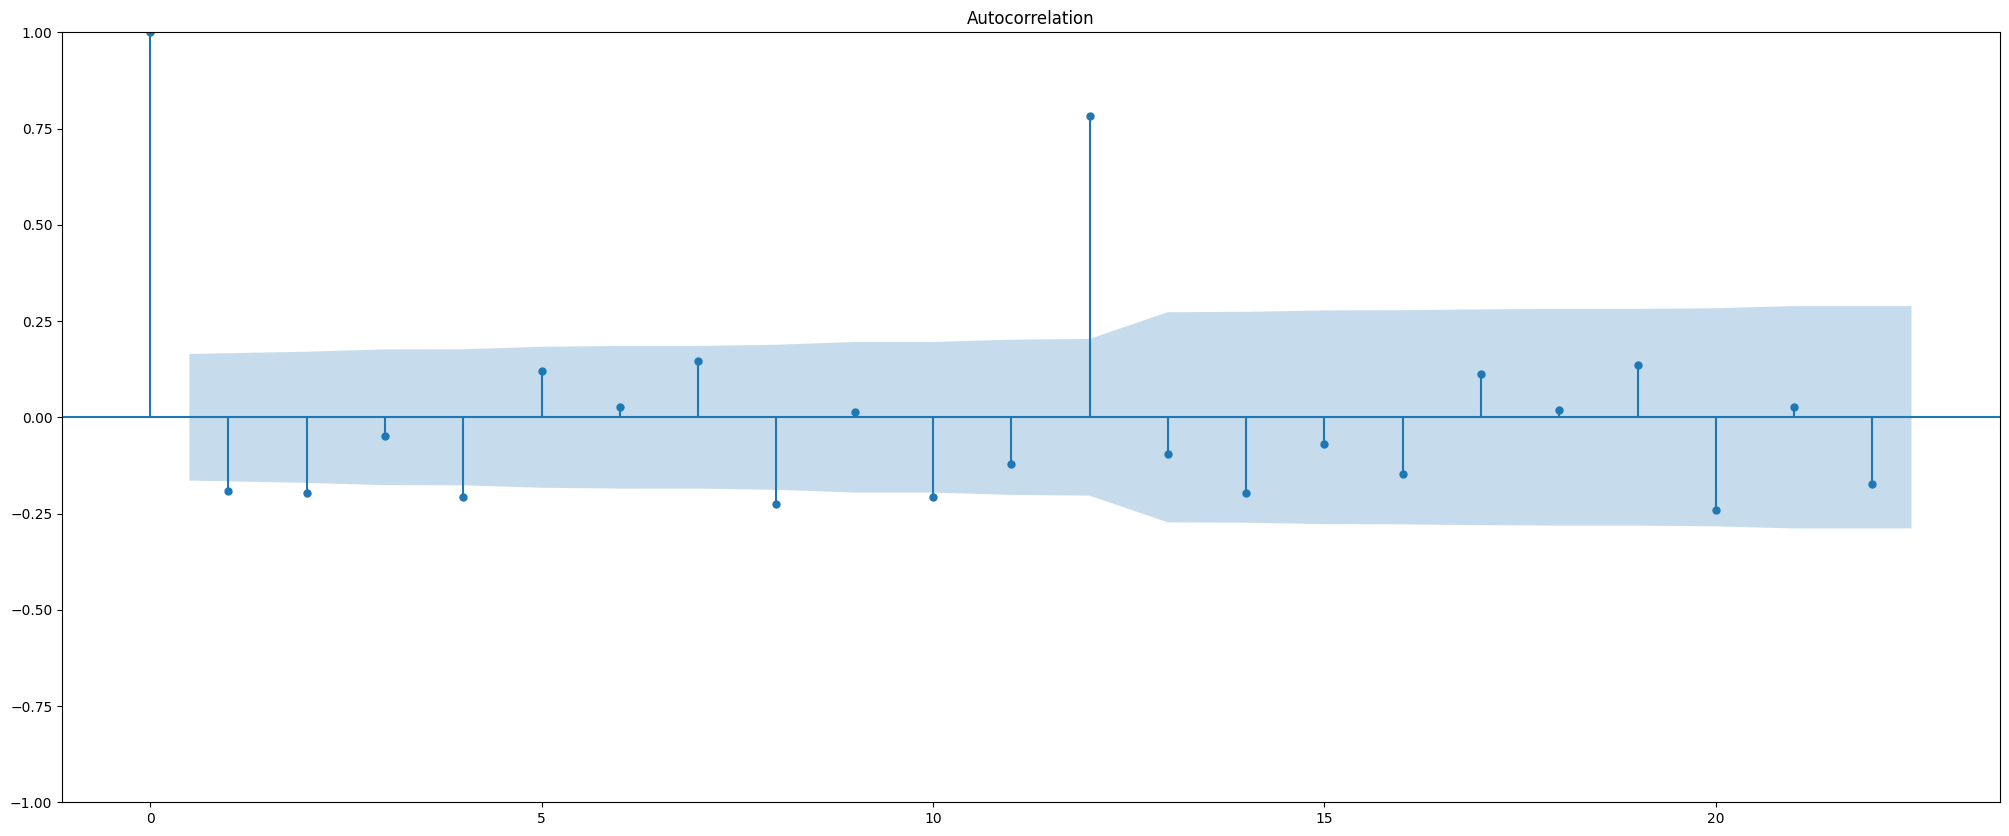

In [ ]:
fig, ax = plt.subplots(figsize=(25, 10))
plot_acf(diff_data.dropna(), ax=ax)
plt.show()

Ahora vemos que el valor 2 es el mejor.

Procedemos a separar la muestra en train y test, pero de forma secuencial debido a que es un problema de series de tiempo.


In [ ]:
# Separar los datos en entrenamiento y prueba
train_size = int(len(df) * 0.8)
train_data, test_data = df[:train_size], df[train_size:]

Vamos a modelar el problema con ARIMA eligiendo los parámetros p, d y q, auto_arima de pdmarima y prophet de facebook.

In [ ]:
# ARIMA
model_arima = ARIMA(train_data['passengers'], order=(11, 2, 2))
model_arima_fit = model_arima.fit()

# auto_arima
model_auto_arima = auto_arima(train_data['passengers'], seasonal=True, m=12)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Realizar predicciones
forecast_arima = model_arima_fit.forecast(steps=len(test_data))
forecast_auto_arima = model_auto_arima.predict(n_periods=len(test_data))

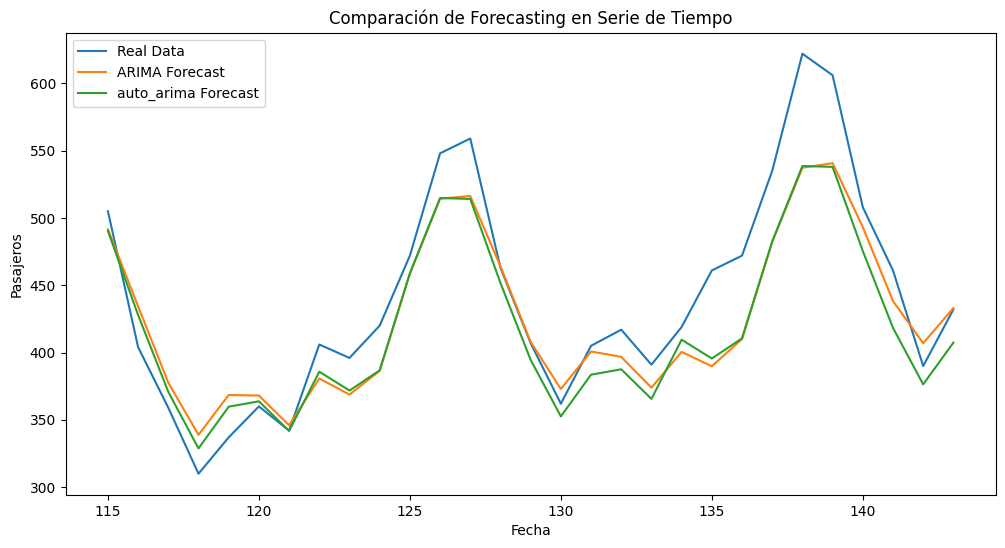

In [ ]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['passengers'], label='Real Data')
plt.plot(test_data.index, forecast_arima, label='ARIMA Forecast')
plt.plot(test_data.index, forecast_auto_arima, label='auto_arima Forecast')
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.title('Comparación de Forecasting en Serie de Tiempo')
plt.legend()
plt.show()

In [ ]:
# Evaluar el rendimiento de los modelos
def evaluate_model(predictions, test):
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    return rmse

rmse_arima = evaluate_model(forecast_arima, test_data['passengers'])
rmse_auto_arima = evaluate_model(forecast_auto_arima, test_data['passengers'])

print(f"RMSE ARIMA: {rmse_arima:.2f}")
print(f"RMSE AUTO ARIMA: {rmse_auto_arima:.2f}")

RMSE ARIMA: 34.40
RMSE AUTO ARIMA: 35.08


In [ ]:
df = pd.read_excel('Sales_Data.xlsx')
df.head()

,Order Date,Sales
0,2015-01-01,14205.707
1,2015-02-01,4519.892
2,2015-03-01,55205.797
3,2015-04-01,27906.855
4,2015-05-01,23644.303


In [ ]:
df.dtypes

,0
Order Date,datetime64[ns]
Sales,float64


<Axes: xlabel='Order Date'>

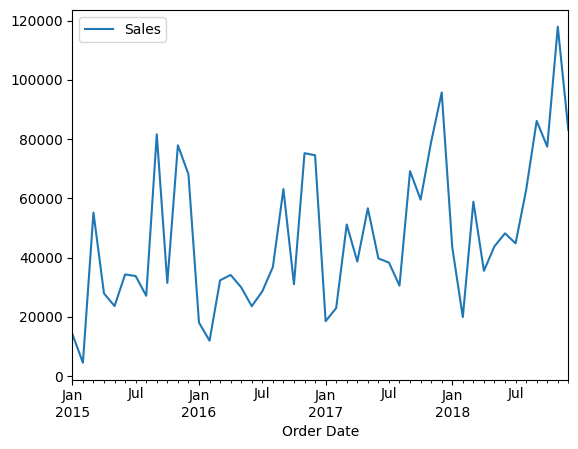

In [ ]:
data = df.set_index('Order Date')
data.plot()


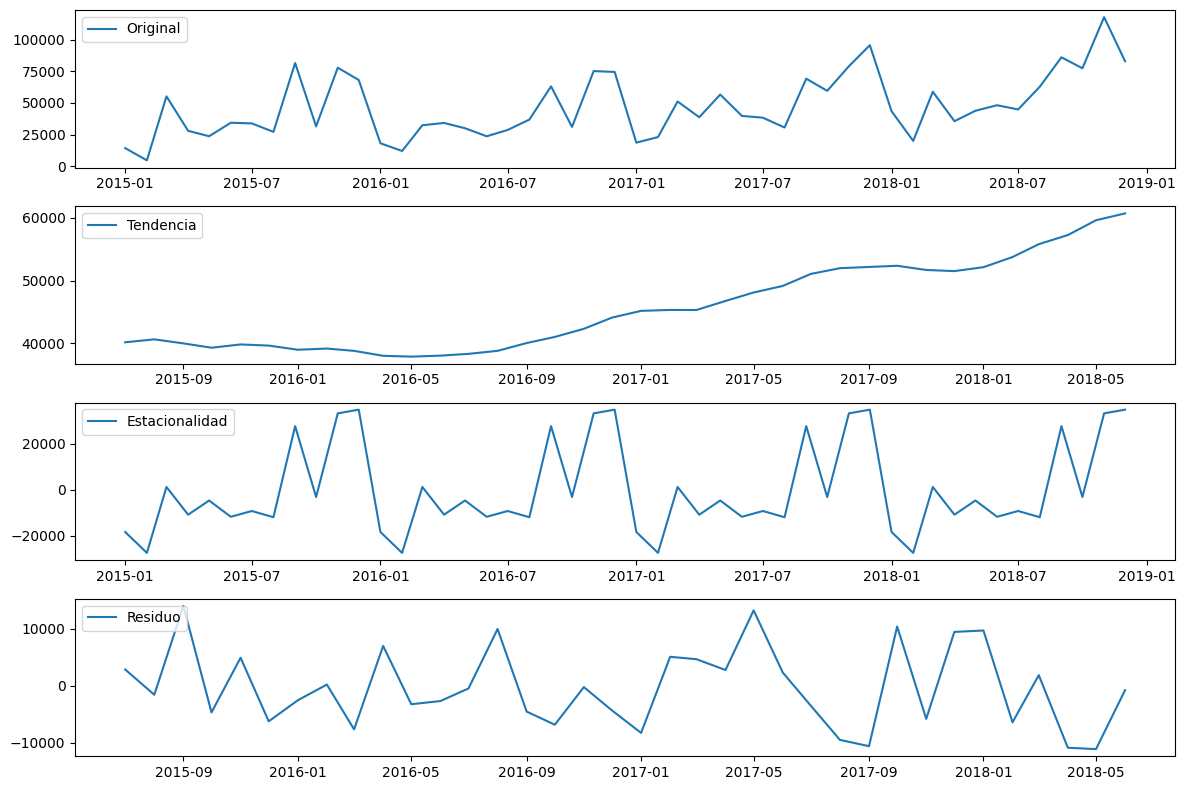

In [ ]:
# Descomposición de la serie de tiempo en componentes
result = seasonal_decompose(data, model='additive')
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Mostrar los componentes descompuestos
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Estacionalidad')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuo')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
#
d = 0
p_value = adfuller(df['Sales'])[1]
diff_data = df['Sales']

while p_value > 0.05:
    diff_data = diff_data.diff()
    p_value = adfuller(diff_data.dropna())[1]
    d += 1


print(f'P Value: {p_value}\t Number of differencing needed: {d}')

P Value: 0.00027791039276670623	 Number of differencing needed: 0
